# Transaction Fee Update Rules: Average Case Analysis

Start by choosing the simulation environment: the update rule and the distribution of valuations. One of the two, will be changing across the experiment according to the bifurcation parameter (learning rate or range of valuations). Let $T/2$ denote the target block-size and let
$$y_t:=\frac{g_t-T/2}{T/2},$$ where $g_t:=g(b_t)$ is the block-size of block at height $t$ given that the basefee is $b_t$. 
---
The **update rule** can be any of 
<!-- - linear : $b_{t+1} = b_t(1+dy_t)$
- exponential : $b_{t+1} = b_t(1+d)^{y_t}$
- amm : $b_{t+1}=\frac{d}{T/2}e^{dz_t}$, where $z_t=\max{\left\{0, z_{t-1}+y_{t-1}\right\}}$ and $z_0=0$
 -->
| Update Rule $\phantom{444444}$ | Description    | Comment  |
| :----------- | :---------- | :----|
| linear      | $b_{t+1} = b_t(1+dy_t)$ |  |
| exponential | $$b_{t+1} = b_t(1+d)^{y_t}\phantom{44444}$$|  |
| amm |$b_{t+1}=\frac{d}{T/2}e^{dz_t}$ | $$\text{where } z_t=\max{\left\{0, z_{t-1}+y_{t-1}\right\}} \text{ and } z_0=0.$$| 
| | |
---
The **distribution of valuations**, $\text{rv}(m,w)$, can be any of

| Distribution $\phantom{44}$ | Parameters |$(\mu, \sigma^2)\phantom{44444}$  | Support | Comment  |
| :----------- | :----- | :------- | :---------| :---- |
| uniform | $m$ | $w^2/12$ | $[m-w/2, m + w/2]$ |
| normal | $m$ |$ w^2/16$  | $(m-w,m+w)$ (essentially)$\phantom{5555}$ |
| gamma | $m+aw$ |$ w^2a$ | $$\hspace{-65pt}[m-aw,+\infty)$$ | $a=1 \to$ exponential| 
|
--- 

<!-- - uniform on $[m-w/2, m + w/2]$: with mean $m$ and variance $w^2/12$.
- normal with mean $m$ and variance $w^2/16$.
- gamma with additional parameter $a$ ($a=1$ corresponds to exponential), starting at $m-aw$ and having parameter $w$, i.e., mean $m+aw$ and variance $w^2a$.
 -->

#### Import packages; initialize parameters and environment

The code in the next cell has the following functionalities
- imports required modules
- defines the dictionary "parameters" with all model parameters
- defines the dictionary "environment" with the update rule and the distribution of valuations
- stores the update rule in ur and the distribution of valuations in rv. Note that one of the two will keep changing later on depending on which (bifurcation) parameter we want to study.

In [35]:
%matplotlib inline
%pylab inline
import scipy
import scipy.stats
import numpy as np
from scipy.optimize import brentq
from collections.abc import Iterable 

def initialize_experiment(rule, distribution, d, w):
    parameters  = {
    "m": 210, 
    "w": w, 
    "d": d, 
    "demand": 2, 
    "premium": 1
    }
    environment = {
    "rule": rule, 
    "distribution": distribution
    }
    return parameters, environment

def dist_valuations(m, w, distribution):
    if distribution == "uniform":
        rv = scipy.stats.uniform(loc = m-w/2, scale = w)
        # uniform distribution with mean $m$ on [m-w/2, m + w/2]
        
    elif distribution == "normal":
        rv = scipy.stats.norm(loc = m, scale = w/4)
        # normal distribution with mean = m on [m-w/2, m+w/2] (essentially: w/2 are 3 stds)
        
    elif distribution == "gamma":
        a  = 0.5
        rv = scipy.stats.gamma(a, loc = m-a*w, scale = w)
        # gamma distribution starting at m-a*w with mean m. if a = 1 this is the exponential
        
    return rv


def update_rule(rule):
    if rule == "linear":
        def fbf(basefee, blocksize, d, exgas):
            y  = 2*blocksize - 1
            ex = max(0, exgas + y)
            bf = basefee*(1 + d*y)
            return bf, ex
        
    elif rule == "exponential":
        def fbf(basefee, blocksize, d, exgas):
            y  = 2*blocksize - 1   
            ex = max(0, exgas + y)
            bf = basefee*(1 + d)**y 
            return bf, ex
    
    elif rule == "amm":
        def fbf(basefee, blocksize, d, exgas):
            y  = 2*blocksize - 1
            ex = max(0, exgas + y)
            bf = (d/500)*np.exp(d*ex)
            return bf, ex
    
    return fbf

Populating the interactive namespace from numpy and matplotlib


The next function provides $b^*$ and the boundaries for the linear rule

In [36]:
def calc_bstar(parameters, rv):
    # is correct only for the uniform distribution
    L = parameters["m"]
    U = parameters["m"] + 4*parameters["w"] 
    #bstar = L - epsilon + (U-L)*(1-1/(2*l));
    bstar = rv.isf(1/(2*parameters["demand"])) - parameters["premium"] 
    bmin  = (1 - parameters["d"])*bstar;
    bmax  = (1 + parameters["d"])*bstar;

    return bstar, bmin, bmax

#### Define main and auxiliary functions for dynamics and plots
In the next cell, we define the main subroutines to run the dynamics

In [37]:
def main_step(bf, parameters, rv, ur, ex):
    blz     = np.min((1, parameters["demand"]*rv.sf(bf + parameters["premium"])))
    bf, ex  = ur(bf, blz, parameters["d"], ex)
    return bf, blz, ex

def IterateList(x, Niter, Nskip, parameters, rv, ur, ex):
    for i in range(Nskip):
        x, blz, ex = main_step(x, parameters, rv, ur, ex)
    
    xs = [x]
    bs = [blz]
    es = [ex]
    
    for i in range(Niter-1):
        x, blz, ex = main_step(x, parameters, rv, ur, ex)
        xs.append(x)
        bs.append(blz)
        es.append(ex)
    
    return xs, bs, es

def run_eip(hyperparameters, rv):
    [dMin, dMax, deltad, x0, e0, Nskip, Niter] = hyperparameters
    dArray = np.arange(dMin, dMax, deltad)
    ds     = []
    dsm    = []
    trajx  = []
    trajxm = []
    trajb  = []
    trajbm = []    
    traje  = []
    trajem = []
    bstars = []
    bmins  = []
    bmaxs  = []
    for d in dArray:
        dsm.extend([d]*1)
        ds.extend([d]*Niter)
        parameters["d"] = d 
        ur = update_rule(environment["rule"])
        xs, bs, es = IterateList(x0, Niter, Nskip, parameters, rv, ur, e0)
        trajx.extend(xs)
        trajb.extend(bs)
        traje.extend(es)
        trajxm.append(np.mean(xs))
        trajbm.append(np.mean(bs))
        trajem.append(np.mean(es))        
        [bstar,bmin,bmax] = calc_bstar(parameters,rv)
        bstars.append(bstar)
        bmins.append(bmin)
        bmaxs.append(bmax)
    return ds, trajx, trajb, traje, dsm, trajxm, trajbm, trajem, bstars, bmins, bmaxs

In the next cell, we define the code to generate the plot

In [38]:
def BifurcationDiagram(output):
    [ds, trajx, trajb, traje, dsm, trajxm, trajbm, trajem, bstars, bmins, bmaxs] = output
    
    plt.subplots(2, 2, sharex = True, figsize=(20,10), tight_layout = True)
    plt.rcParams['font.size'] = '16'
    
    plt.subplot(221)
    xlim((0,ds[-1]+0.01))
    scatter(ds, trajx, marker ='.', s = 0.1)
    plot(dsm,bstars,'r', linewidth=0.81)
    plot(dsm,bmins,'--r',linewidth=0.81)
    plot(dsm,bmaxs,'--r',linewidth=0.81)
    ylabel('Basefee')
    title('Individual trajectories')
    
    plt.subplot(222)
    scatter(dsm, trajxm, marker ='.', s = 1)
    plot(dsm,bstars,'r', linewidth=0.81)
    plot(dsm,bmins,'--r',linewidth=0.81)
    plot(dsm,bmaxs,'--r',linewidth=0.81)
    lgnd = legend(['$b*$','$(1-d)b*$', '$(1+d)b*$','base fee $b_t$'], bbox_to_anchor=(1.3,1.035), loc="upper right")
    lgnd.legendHandles[3]._sizes = [50]   
    title('Averages')
    
    plt.subplot(223)
    scatter(ds, trajb, marker ='.', s = 0.1)
    #xlabel('Range of valuations $w$')
    ylabel('Block-size')
            
    plt.subplot(224)
    scatter(dsm, trajbm, marker ='.', s = 1)
    #xlabel('Range of valuations $w$')
    
#     plt.subplot(325)
#     scatter(ds, traje, marker ='.', s = 0.1)
#     ylim((min(traje)-2, max(traje)+1))
#     xlabel('Adjustment quotient $d$')
#     ylabel('Excess gas')
            
#     plt.subplot(326)
#     scatter(dsm, trajem, marker ='.', s = 1)
#     ylim((min(traje)-2, max(traje)+1))
#     xlabel('Adjustment quotient $d$')
    

#### Run the dynamic
The next routine runs the dynamic and returns the trajectories of blocksizes and basefees. First, in the next, set the parameters of the experiment
- hyperparameters = [`dMin, dMax, Deltad, x0, e0, Nskip, Niter`]
- output = [`ds, trajx, trajb, dsm, trajxm, trajbm, bstars, bmins, bmaxs`]

where `ds`, `trajx` (basefees), `trajb` (blocksizes) refer to individual trajectories and `dsm`, `trajxm`, `trajbm` to averages. The ideal values (that achieve 0.5 blocksize) are stored in `bstars` and `bmins, bmaxs` refer to the bounds for the linear-EIP1559.

In [57]:
parameters, environment = initialize_experiment(rule = "linear", distribution = "normal", d = 0.125, w = 10) 
rv = dist_valuations(parameters["m"], parameters["w"], environment["distribution"])

In [72]:
hyperparameters = [0.001, 0.7, 0.0005, 200, 0, 100, 300] # dMin, dMax, Deltad, x0, e0, Nskip, Niter

In [73]:
output = run_eip(hyperparameters, rv)

#### Plots
Using the outputs from the previous routine "run_eip()", we plot the bifurcation diagrams in the next cell

In [115]:
def BifurcationDiagram_individual(output):
    [ds, trajx, trajb, traje, dsm, trajxm, trajbm, trajem, bstars, bmins, bmaxs] = output
    
    plt.subplots(2, 1, sharex = True, figsize=(50,50), tight_layout = True)
    plt.rcParams['font.size'] = '60'
    
    plt.subplot(211)
    xlim((0,ds[-1]+0.01))
    scatter(ds, trajx, marker ='.', s = 50)
    plot(dsm,bstars,'r', linewidth=0.81)
    plot(dsm,bmins,'--r',linewidth=0.81)
    plot(dsm,bmaxs,'--r',linewidth=0.81)
    ylabel('Base fee', fontsize = 60)
    xlim([0, 0.3])
    ylim([140, 280])
    title('Individual trajectories', fontsize = 60)
      
    plt.subplot(212)
    scatter(ds, trajb, marker ='.', s = 50)
    xlim([0, 0.3])
    xlabel('Learning rate $d$')
    ylabel('Block-sizes',fontsize =60)    

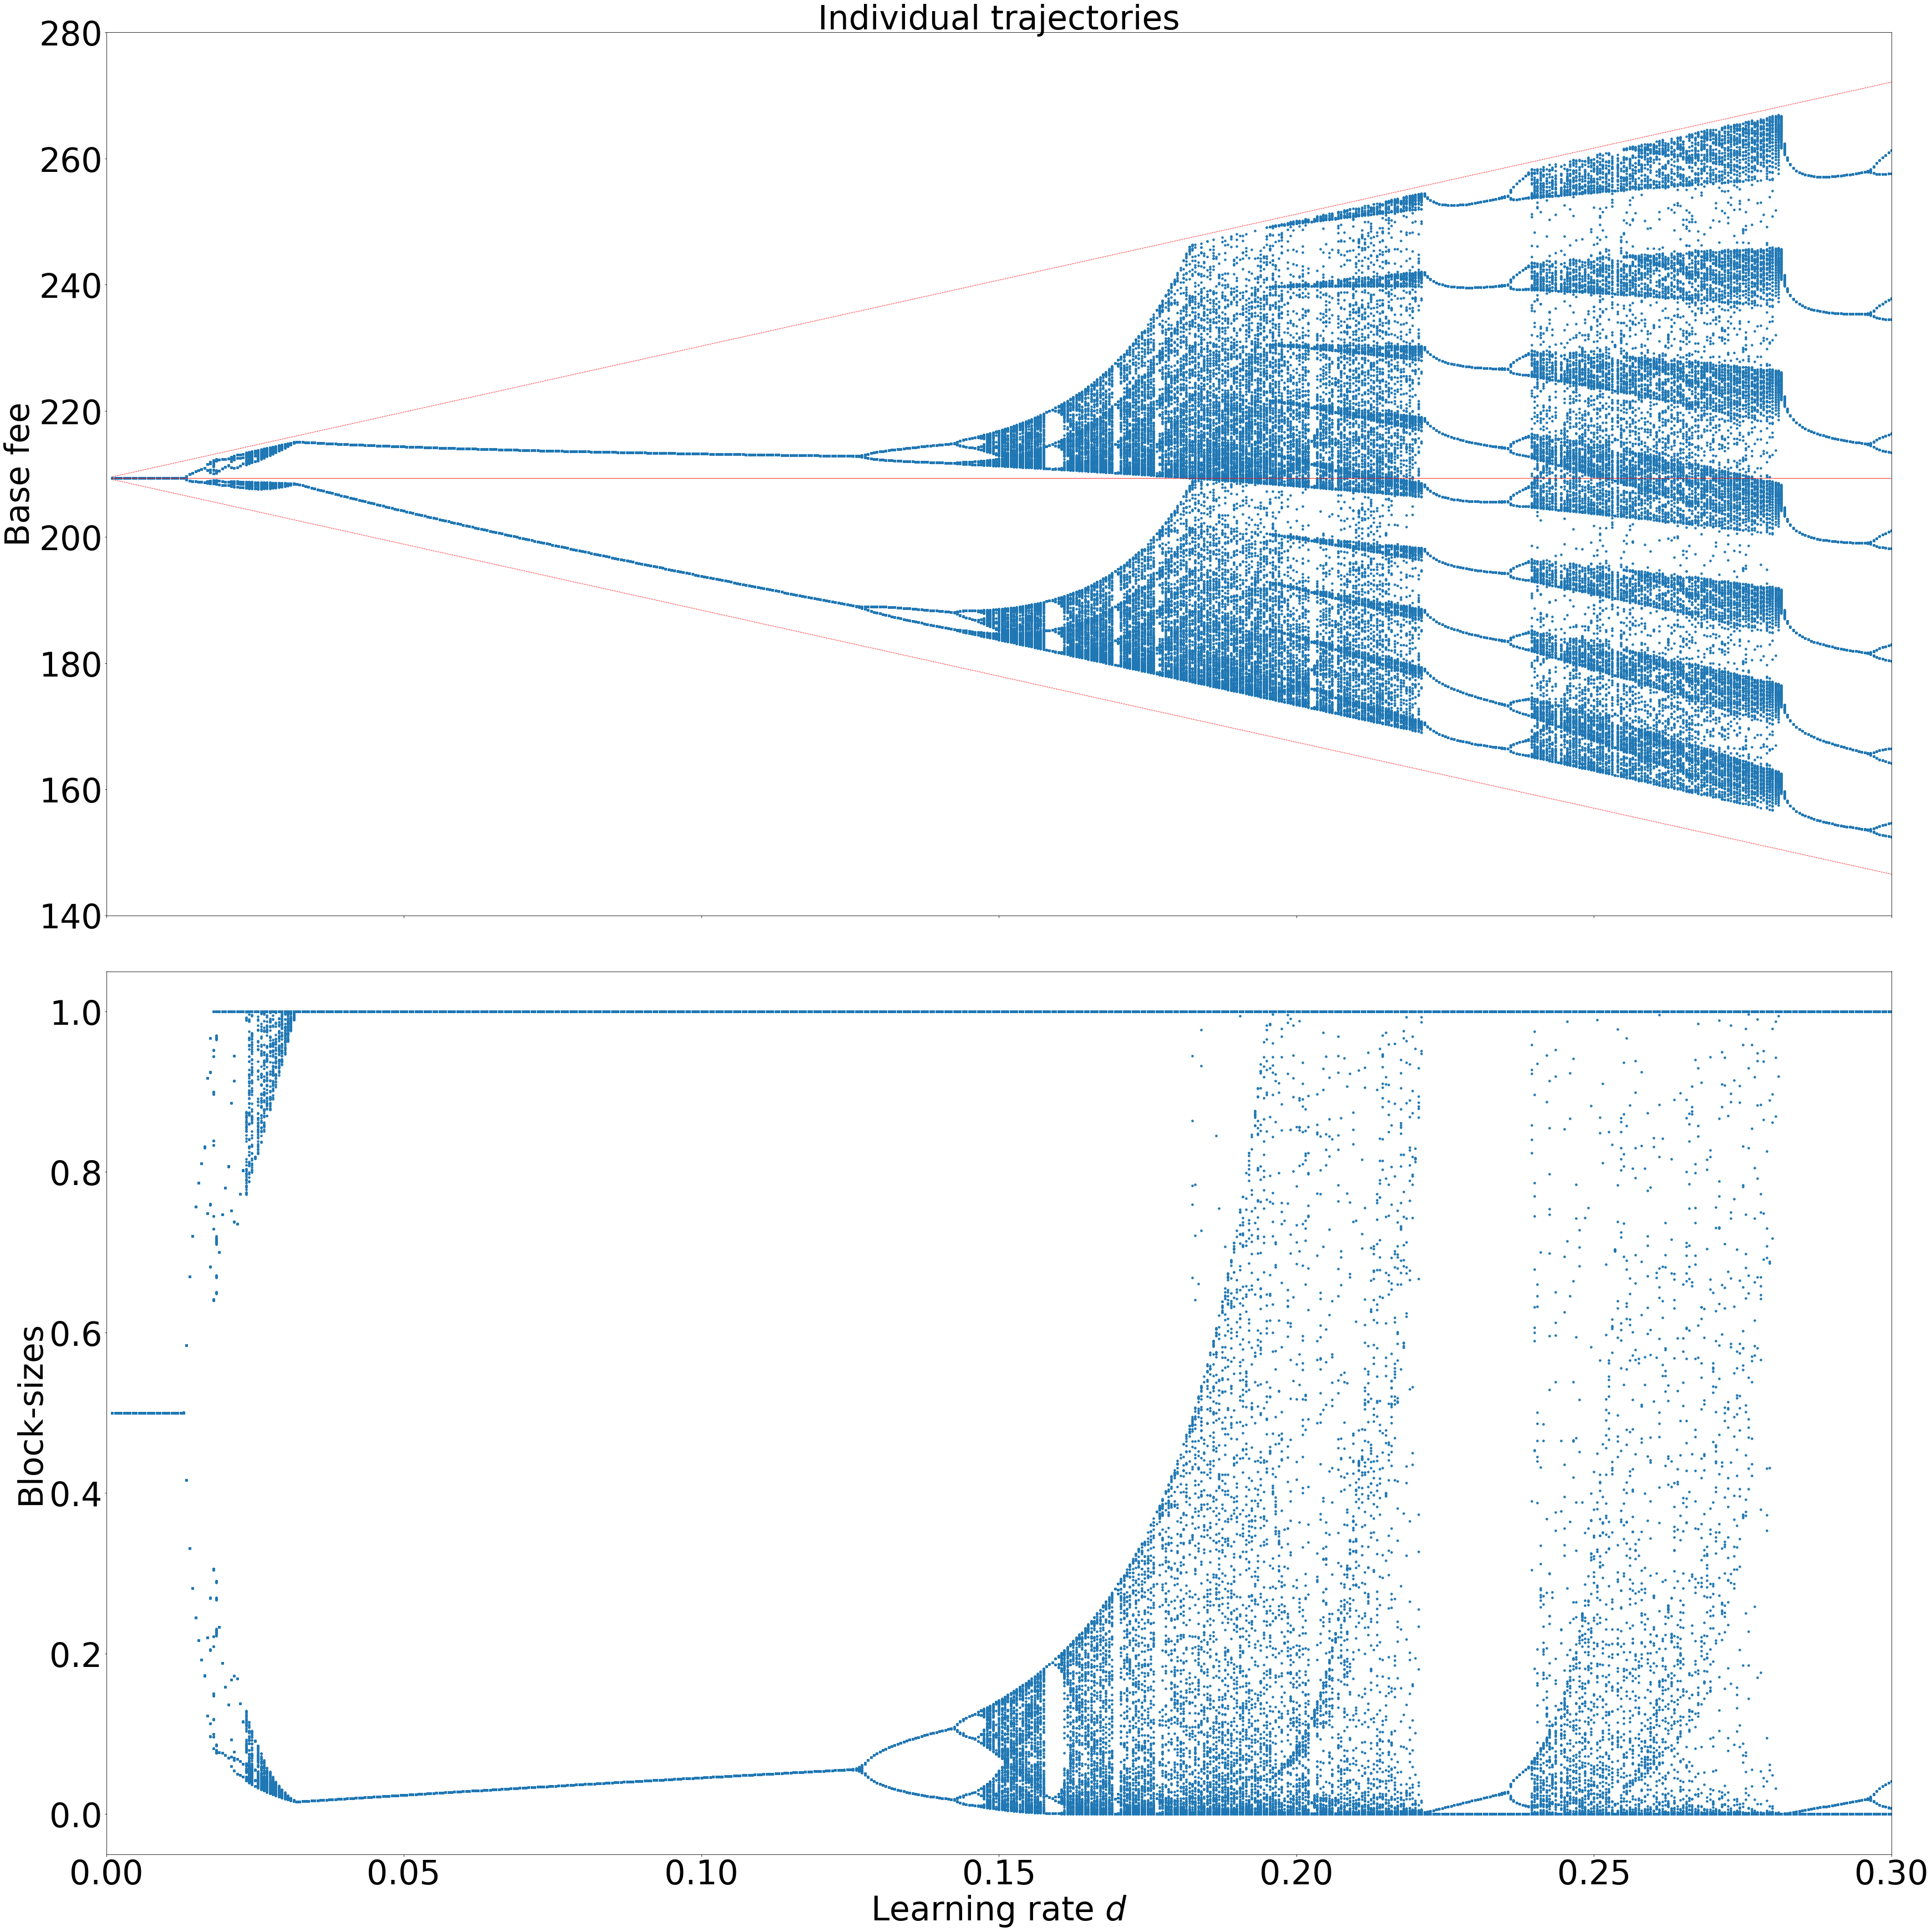

In [117]:
BifurcationDiagram_individual(output)
savefig('bf_rate_individual_normal.jpg',bbox_inches='tight', dpi=50)

Zoom-in in the first plot

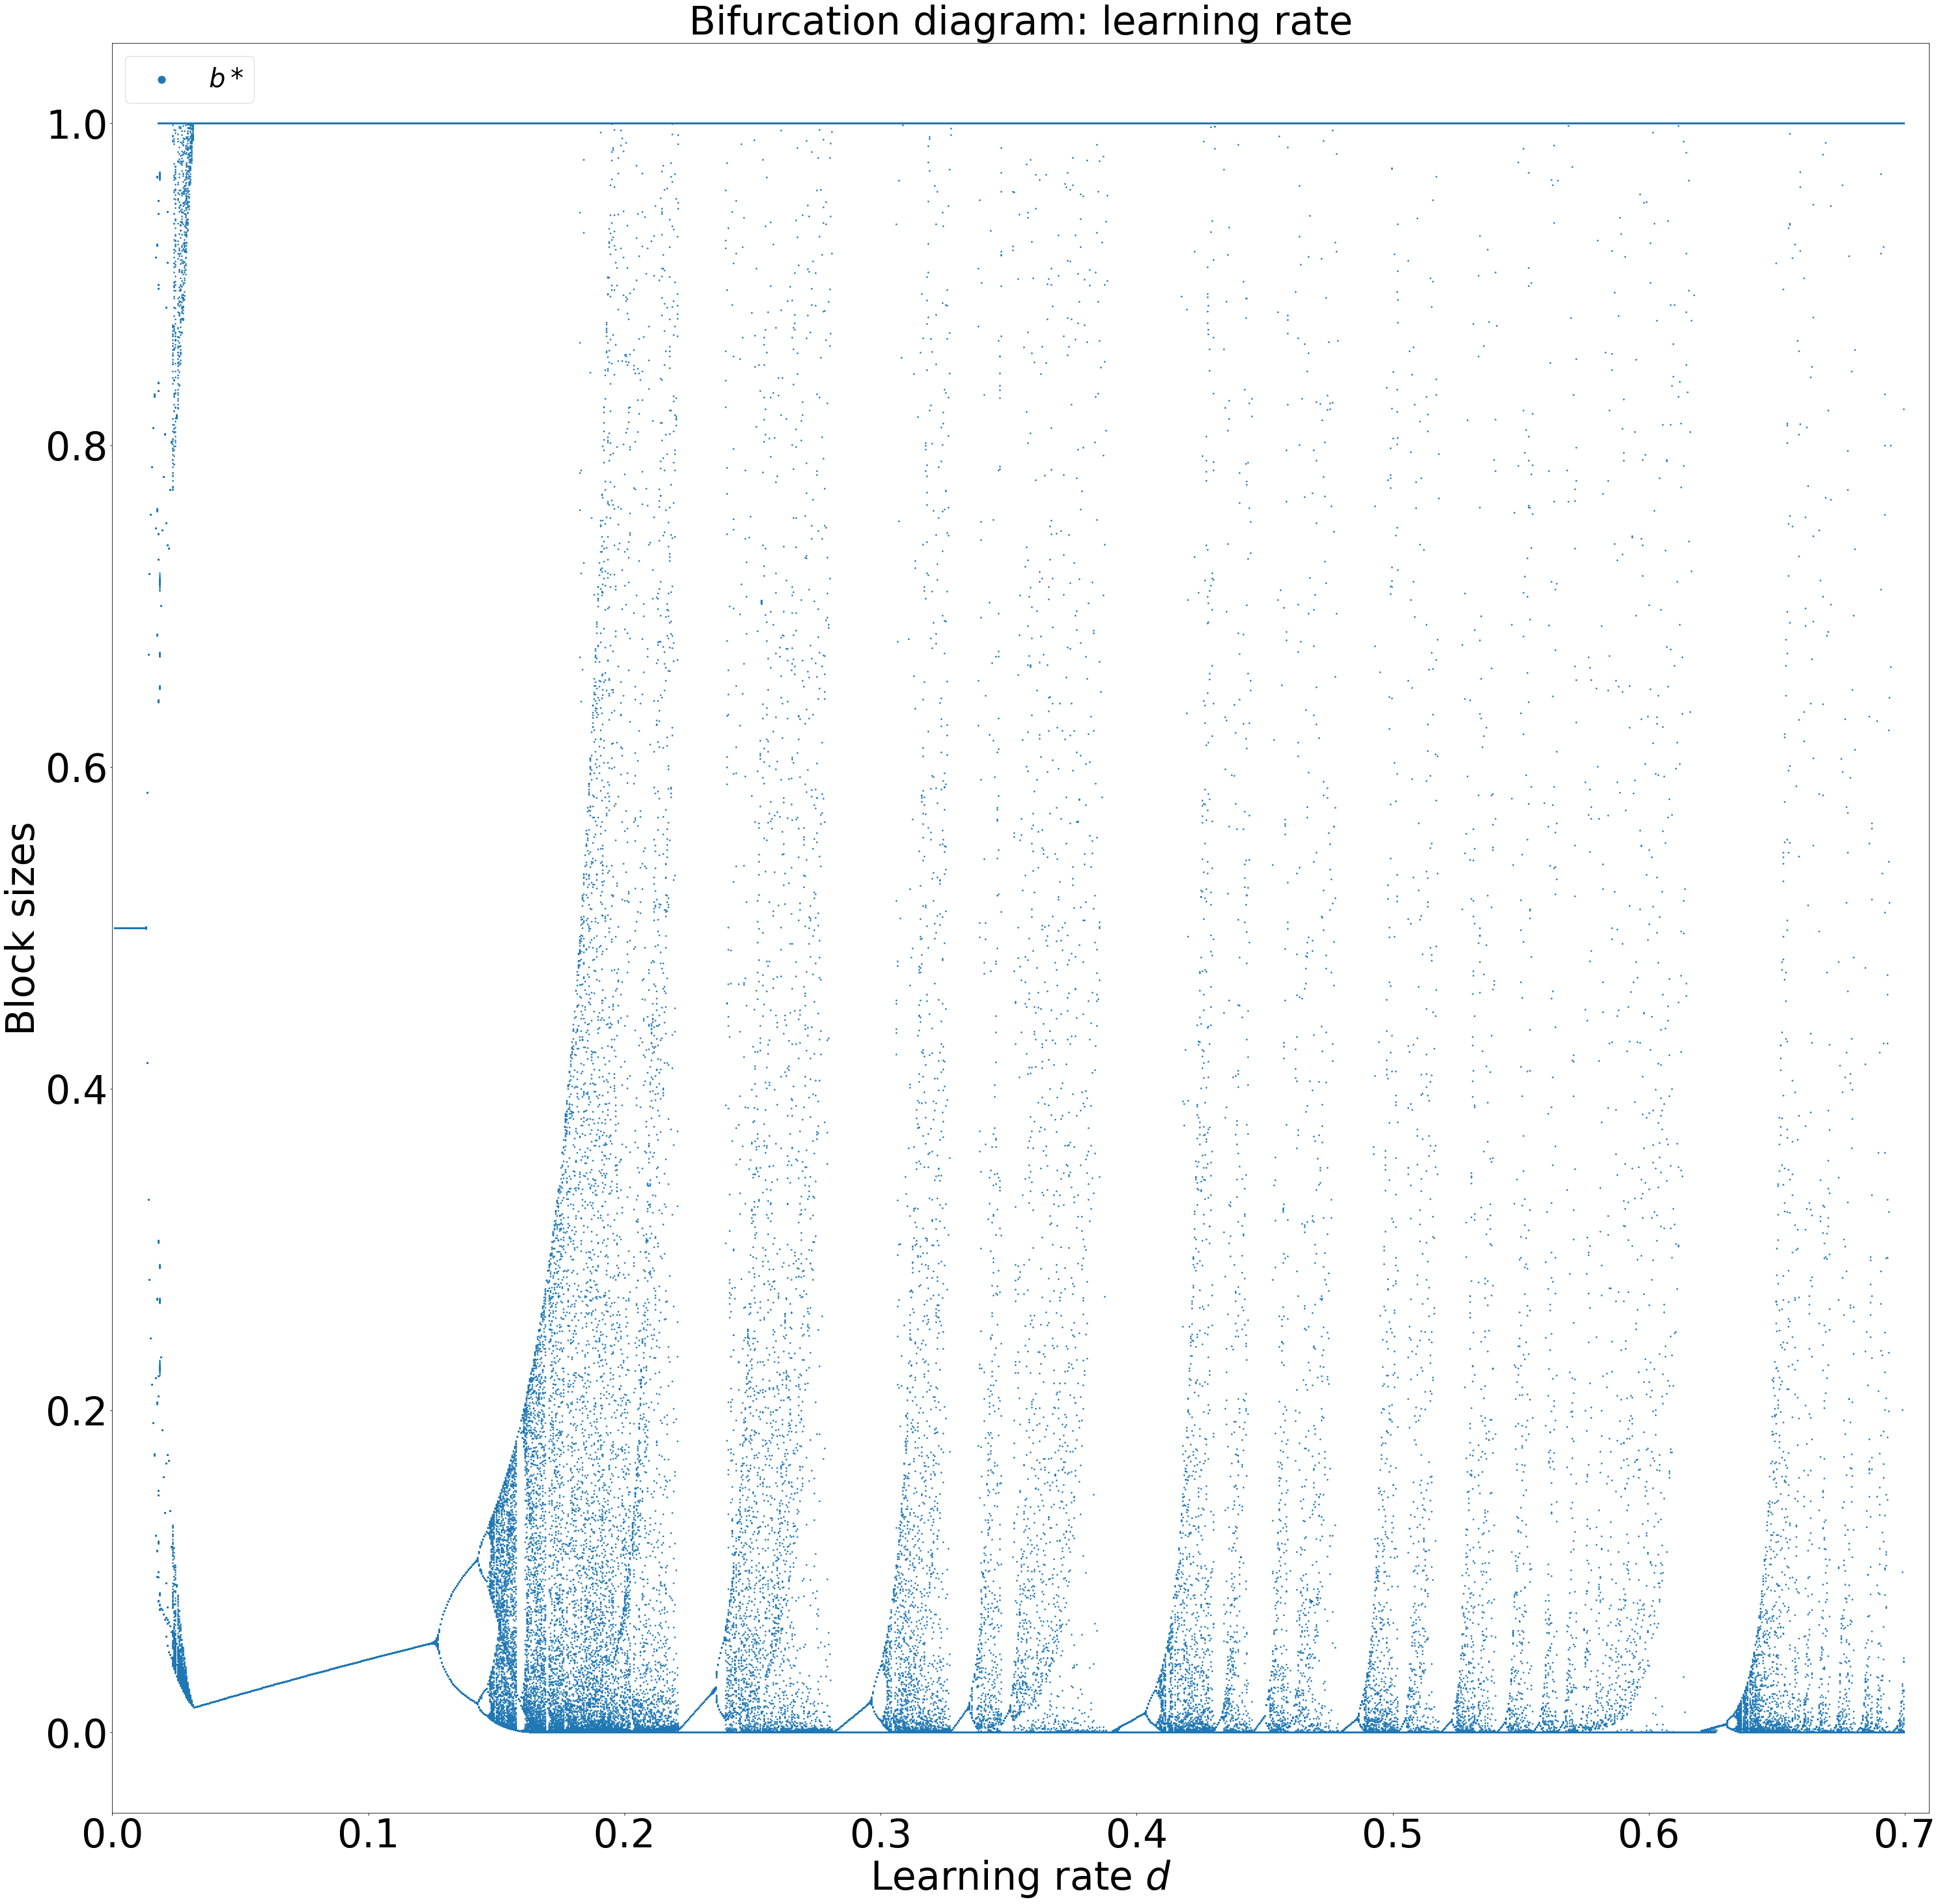

In [75]:
#savefig('base_fee_lin.jpg',bbox_inches='tight', dpi=1200)
[ds, trajx, trajb, traje, dsm, trajxm, trajbm, trajem, bstars, bmins, bmaxs] = output
plt.figure(figsize(50,50))
xlim((0,ds[-1]+0.01))
scatter(ds, trajb, marker ='.', s = 10)
# plot(dsm,bstars,'r', linewidth=0.81)
# plot(dsm,bmins,'--r',linewidth=0.81)
# plot(dsm,bmaxs,'--r',linewidth=0.81)
# ylabel('Basefee')
# title('Individual trajectories')
xlabel('Learning rate $d$', fontsize=60)
ylabel('Block sizes', fontsize=60)
lgnd = legend(['$b*$','$(1-d)b*$', '$(1+d)b*$','basefee $b_t$'], fontsize =40, loc = "upper left")
lgnd.legendHandles[0]._sizes = [500]
title('Bifurcation diagram: learning rate', fontsize = 60)
plt.xticks(fontsize=60);
plt.yticks(fontsize=60);
#savefig('bz_normal.jpg',bbox_inches='tight', dpi=50)

In [103]:
def BifurcationDiagram_average(output):
    [ws, trajx, trajb, traje, wsm, trajxm, trajbm, trajem, bstars, bmins, bmaxs] = output
    
    plt.subplots(1, 2, sharex = True, figsize=(80,20), tight_layout = True)
    plt.rcParams['font.size'] = '60'
    
    # plt.subplot(211)
    # xlim((ws[0]-1,ws[-1]+1))
    # scatter(ws, trajx, marker ='.', s = 0.1)
    # plot(wsm,bstars,'r')
    # plot(wsm,bmins,'--r')
    # plot(wsm,bmaxs,'--r')
    # ylabel('Basefee')
    # title('Individual trajectories')
    
    plt.subplot(121)
    scatter(wsm, trajxm, marker ='.', s = 50)
    plot(wsm,bstars,'r')
    plot(wsm,bmins,'--r')
    plot(wsm,bmaxs,'--r')
    #lgnd = legend(['$b*$','$(1-d)b*$', '$(1+d)b*$','base fee $b_t$'], bbox_to_anchor=(1.3,1.035), loc="upper right")
    lgnd = legend(['$b*$','$(1-d)b*$', '$(1+d)b*$','base fee $b_t$'], loc="upper left")
    lgnd.legendHandles[3]._sizes = [500]   
    #title('Averages: base fee (up), block sizes (down)')
    # xlabel('Demand range $w$', fontsize=60)
    ylabel('Base fee dynamics', fontsize=60)
    xlabel('Learning rate $d$', fontsize=60)
    plt.xticks(fontsize=60);
    plt.yticks(fontsize=60);
    xlim([0, 0.6])

    #savefig('bf_demand_normal.jpg',bbox_inches='tight', dpi=50)
    
    # plt.subplot(323)
    # scatter(ws, trajb, marker ='.', s = 0.1)
    # #xlabel('Range of valuations $w$')
    # ylabel('Block-size')
            
    plt.subplot(122)
    scatter(wsm, trajbm, marker ='.', s = 50)
    ylabel('Block sizes', fontsize=60)
    xlabel('Learning rate $d$',fontsize=60)
    xlim([0, 0.6])
    plt.ylim(top=0.67)
    lgnd = legend(['base fee $b_t$','$(1-d)b*$', '$(1+d)b*$','base fee $b_t$'], loc="upper left")
    lgnd.legendHandles[0]._sizes = [500] 
    
#     plt.subplot(325)
#     scatter(ws, traje, marker ='.', s = 0.1)
#     ylim((min(traje)-2, max(traje)+1))
#     xlabel('Range of valuations $w$')
#     ylabel('Excess gas')
            
#     plt.subplot(326)
#     scatter(wsm, trajem, marker ='.', s = 1)
#     ylim((min(traje)-2, max(traje)+1))
#     xlabel('Range of valuations $w$')

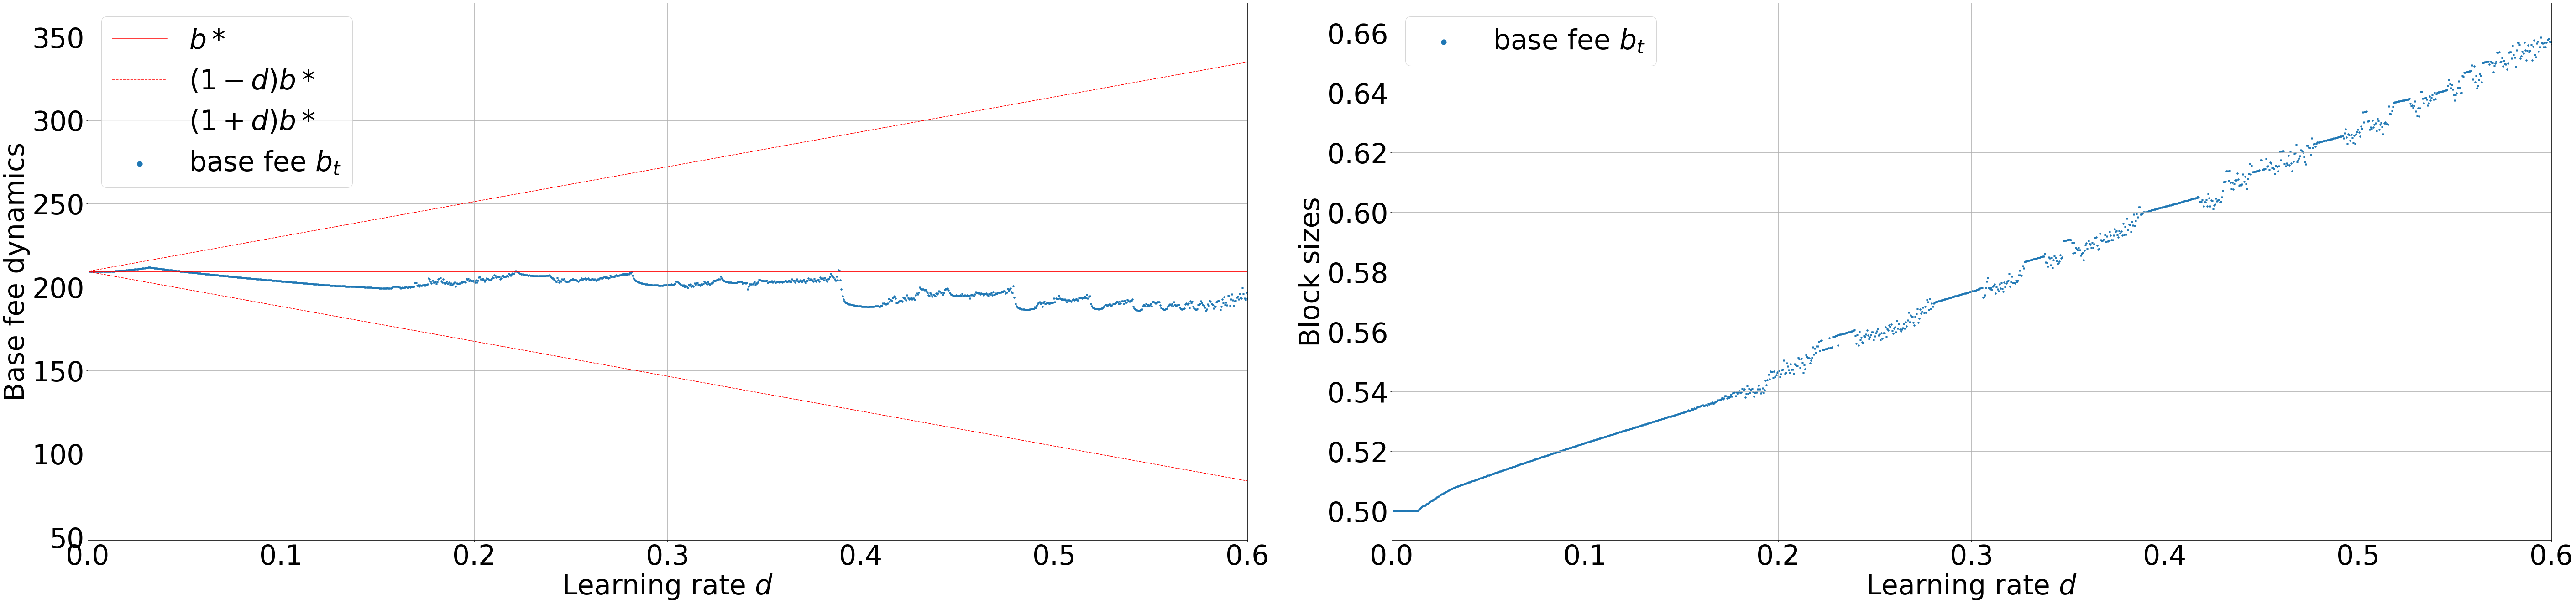

In [104]:
BifurcationDiagram_average(output)
#savefig('bf_rate_averages_normal.jpg',bbox_inches='tight', dpi=50)